# **Métodos Computacionales I - Parcial #4**

**Hecho por:** Claudia Alejandra Cuellar Nieto & Thomas Andrade Hernández


In [2]:
# Zona de librerías:
import numpy as np
import sympy as sym
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scipy.optimize as spo
from scipy.stats import norm
from tqdm import tqdm

> **Rotación de la Tierra:**

$$ y(h) = \frac{2\sqrt{2}}{3}\omega \cos (\lambda) \sqrt{\frac{h^3}{g}} $$

Este es el modelo físico que debe ajustar para estimar la rapidez de rotación en cada
latitud y luego hacer el best-fit model combinando la información de todas latitudes (o
canales). Los datos experimentales se refieren a la altura inicial, al desplazamiento $(y(h))$ observado en cada latitud y al error experimental $(\sigma(y))$. Les propongo la siguiente estrategia para hacer esta estimación:

**$a)$** Descarguen los datos experimentales de cada canal de observación: https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/DataRotacion.csv.

**$b)$** Cargue los datos usando **Pandas** y haga un filtrado para obtener los datos
correspondientes a $\lambda = 30$.

In [3]:
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/DataRotacion.csv'
data = pd.read_csv(url)
data

,h,angle,y,sigmay
0,10.0,10.0,0.0017,0.0015
1,20.0,10.0,0.0016,0.0015
2,30.0,10.0,0.0027,0.0015
3,40.0,10.0,0.0055,0.0015
4,50.0,10.0,0.0083,0.0015
5,60.0,10.0,0.0085,0.0015
6,70.0,10.0,0.0096,0.0015
7,80.0,10.0,0.0144,0.0015
8,90.0,10.0,0.0200,0.0015
9,100.0,10.0,0.0208,0.0015


In [9]:
def Filter(angle):
  D = data.copy()
  D.drop(D[(D['angle'] != angle) ].index, inplace=True)
  return D

def Data(D):
  y = np.array(D['y'])
  h = np.array(D['h'])
  sigmay = np.array(D['sigmay'])
  N = len(y)
  return y, h, sigmay, N

D = Filter(30)
D

,h,angle,y,sigmay
20,10.0,30.0,0.0013,0.0015
21,20.0,30.0,0.0017,0.0015
22,30.0,30.0,0.0038,0.0015
23,40.0,30.0,0.0059,0.0015
24,50.0,30.0,0.0067,0.0015
25,60.0,30.0,0.0094,0.0015
26,70.0,30.0,0.0122,0.0015
27,80.0,30.0,0.0132,0.0015
28,90.0,30.0,0.0151,0.0015
29,100.0,30.0,0.0186,0.0015


**$c)$** Defina el modelo físico presentado para la desviación por efecto coriolis. El modelo debe tener como entrada la altura inicial de caída $h$, el parámetro de ajuste $p = \omega$, la latitud $\lambda$ y la aceleración de la gravedad $g$.

In [10]:
def Model_y(h, omega, lambda_, g):
    return ((2*np.sqrt(2)) / 3 ) * omega * np.cos(lambda_*np.pi/180) * np.sqrt((h**3/g))

**$d)$** Defina la función $\Chi ^2$, donde los argumentos son $(h, y, sigmay, angle, g)$.


In [11]:
def X2_Function(omega, y, h, sigmay, g, lambda_):
    return np.sum ((y - Model_y(h, omega, lambda_, g))**2/(2*sigmay**2) )

**$e)$** Minimice usando **optimize**. Para $\lambda = 30$, debería obtener $\hat{\omega} = 7.24 \cdot 10^{−5}$.


In [13]:
y, h, sigmay, N = Data(D)
p0 = np.ones(1)
nll = lambda *p: X2_Function(*p)
result = minimize(nll, p0, args = (y, h, sigmay, 9.81, 30), options = {'disp':True})
bestparam = result.x

Optimization terminated successfully.
         Current function value: 1.145718
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4


In [14]:
print("El valor ω obtenido es, aproximadamente: {}".format(result.x[0]))

El valor ω obtenido es, aproximadamente: 7.243998042010358e-05


**$f)$** Dibuje los datos y el modelo para esa latitud.

<ErrorbarContainer object of 3 artists>

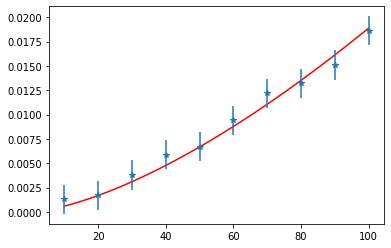

In [15]:
_x = np.linspace(np.min(h),np.max(h),1000)
_y = Model_y(_x,bestparam, 30, 9.81)
plt.plot(_x,_y,color='r')
plt.errorbar(h, y, yerr = sigmay, fmt = '*')

# **Propagación de la incertidumbre de la aceleración de la gravedad:**

**$a)$** Hacer un for loop $N = 300$ veces para realizar el remuestreo del valor de la gravedad de los puntos experimentales.

**$b)$** Genere un valor de gravedad siguiendo la distribución normal $g \backsim N (9.8, 1)$: **$9.81 + np.random.normal(loc=0,scale=1)$** .

**$c)$** Guarde ese valor en un array llamado Gravedad.

**$d)$** Cambie el valor de los puntos experimentales siguiendo la distribución normal $y \backsim N (y, \sigma(y))$: (modificación de bootstrapping): 
**$y + np.random.normal( loc=0, scale=sigmay[0], size=len(y))$**.

**$e)$** Realice la optimización y guarde el valor de la estimación de la rapidez angular $\hat{\omega}$ en otro array, Omega.

In [17]:
N = 300

def Omega_Stimation(y, h, sigmay, lambda_):
  Gravedad = np.zeros(N)
  Omega = np.zeros(N)

  for i in range(N):
      g = 9.81 + np.random.normal(loc  = 0, scale = 1)
      Gravedad[i] = g

      y_nuevo = np.abs(y + np.random.normal( loc = 0, scale = sigmay[0], size = len(y)))
      
      result = minimize(nll, x0 = [0], args = (y_nuevo, h, sigmay, Gravedad[i], lambda_), options={'disp':False})

      Omega[i] = result.x
  return Gravedad, Omega

**$f)$** Genere la distribución conjunta $f(\omega, g)$. Elija bien el tamaño de caja (cuente los cuadros en la figura por ejemplo). **$H2,binsx,binsy = np.histogram2d(Omega,Gravedad,bins=(binsx,binsy))$**

In [18]:
def Histogram_Data(Gravedad, Omega):
  gridy = np.linspace(min(Gravedad),max(Gravedad),30)
  gridx = np.linspace(min(Omega),max(Omega),30)
  H2, binsx, binsy = np.histogram2d(Omega, Gravedad, bins=(gridx,gridy))
  return H2, binsx, binsy

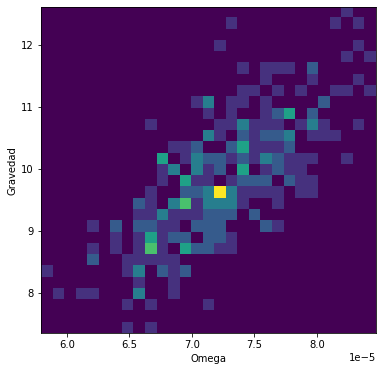

In [21]:
Gravedad_30, Omega_30 = Omega_Stimation(y, h, sigmay, 30)
H2_30, binsx_30, binsy_30 = Histogram_Data(Gravedad_30, Omega_30)

plt.figure(figsize = (6,6))
plt.imshow(H2_30.T, origin='lower', extent=[binsx_30[0], binsx_30[-1], binsy_30[0], binsy_30[-1]], aspect='auto')
plt.xlabel('Omega')
plt.ylabel('Gravedad')
plt.show()

**$e)$** ¿Están las variables correlacionadas?

Como se puede observar, la densidad de distribución adquiere una forma muy similar a la que tendría una serie de datos relacionados linealmemte. Por esta situación es posible afirmar que ciertamente existe una correlación entre el valor de la gravedad y el omega de nuestro interés.

**$f)$** Marginalice $f(\omega, g)$ para encontrar la distribución $h(\omega)$.

$$ h(\omega) = \sum_{m} f(\omega, g_m) $$

**$\verb|H1 = np.sum(H2, axis = 1)|$**

**$g)$** Usando $h(\omega)$ obtenga el mejor estimador $\hat{\omega}$ y el intervalo de confianza a un sigma de desviación. En este caso, use los percentiles para histogramas:

**$\verb|cs = np.cumsum(H1)|$**

**$\verb|ij = np.searchsorted(cs, np.percentile(cs,16))|$**

**$\verb|ii = np.searchsorted(cs, np.percentile(cs,50))|$**

**$\verb|ji = np.searchsorted(cs, np.percentile(cs,84))|$**


In [22]:
def Looking_For_Intervals(H2, binsx):
  H1 = np.sum(H2,axis=1)
  cs = np.cumsum(H1)
  ij = np.searchsorted(cs, np.percentile(cs, 16))
  ii = np.searchsorted(cs, np.percentile(cs, 50))
  ji = np.searchsorted(cs, np.percentile(cs, 84))

  best_estimator = binsx[ii]
  lower_limit = binsx[ij]
  upper_limit = binsx[ji]
  return best_estimator, lower_limit, upper_limit

best_estimator_30, lower_limit_30, upper_limit_30 = Looking_For_Intervals(H2_30, binsx_30)

print("Mejor estimador de ω para la latitud λ = 30:", best_estimator_30)
print("Intervalo de confianza (σ de desviación) para λ = 30:", lower_limit_30, "&", upper_limit_30)

Mejor estimador de ω para la latitud λ = 30: 7.08630723534933e-05
Intervalo de confianza (σ de desviación) para λ = 30: 6.162671502790158e-05 & 8.009942967908504e-05


**$h)$** Para la latitud $\lambda = 30$, El mejor estimador es aproximadamente $\hat{\omega} = 7.30 \cdot 10^{−5}$ y
el intervalo de confianza a $1\sigma$ es:

$$ IC_{68\% } = [6.42,8.18] \cdot 10^{-5} $$

Haga el ejercicio para cada latitud, resumiendo los valores en una tabla:


| $\lambda$ | $\hat{\omega} \cdot 10^{-5}$ | $IC_{68\%}$ | $\sigma^+/ \hat{\omega}$ |
| --- | --- | --- | --- |
| 10 | 7.03 | [6.25,7.89] | 0.067 |
| 20 | 6.83 | [5.94,7.82] | 0.066 |
| 30 | 7.30 | [6.42,8.18] | 0.085 |
| 40 | 7.50 | [6.57,8.53] | 0.100 |
| 50 | 6.72 | [5.73,7.83] | 0.126 |
| 60 | 7.35 | [6.27,8.56] | 0.150 |
| Combined | 7.04 | [6.30,7.87] | 0.036 |


In [23]:
x_value, y_value, y_error = [], [], []

for i in range(1, 7):
  y_, h_, sigmay_, N_ = Data(Filter(i*10))
  Gravedad_, Omega_ = Omega_Stimation(y_, h_, sigmay_, i*10)
  H2_, binsx_, binsy_ = Histogram_Data(Gravedad_, Omega_)
  best_estimator, lower_limit, upper_limit = Looking_For_Intervals(H2_, binsx_)
  
  x_value.append(i*10)
  y_value.append(best_estimator)
  y_error.append(np.abs((upper_limit - lower_limit)/2))

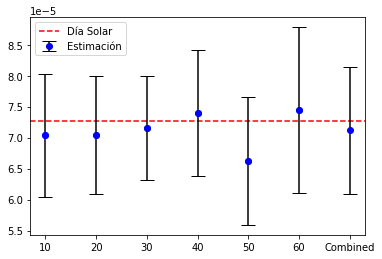

In [30]:
plt.scatter(x_value, y_value)
plt.axhline(7.27e-5, linestyle = 'dashed', color = 'r', label="Día Solar")
for i in range(len(x_value)):
  ax = plt.errorbar(x_value[i], y_value[i], linestyle="None", yerr = y_error[i], fmt="ob", capsize=7, ecolor="k")
plt.errorbar(70, np.sum(y_value)/len(y_value), linestyle="None", yerr = np.sum(y_error)/len(y_error), fmt="ob", capsize=7, ecolor="k", label = "Estimación")
plt.xticks(x_value + [70],["10", "20", "30", "40", "50", "60", "Combined"])
plt.legend()
plt.show()

La rapidez angular de la tierra calcula con la duración del día solar es: $\omega _T = 7.27 \cdot 10^{−5}$ rad/s.